<a href="https://colab.research.google.com/github/MahzadKania57/2D-Keypoints-based-Pose-Classifier/blob/master/Human_skeleton_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download Dataset

In [1]:
!rm -rf "/content/sample_data/keypoints"
!rm -rf "/content/sample_data/keypoints_test"

In [2]:
%cd /content/sample_data
!mkdir keypoints
%cd keypoints
!mkdir raw
!mkdir processed
%cd raw  
!wget https://raw.githubusercontent.com/tringn/2D-Keypoints-based-Pose-Classifier/master/dataset/X_train.txt 
!wget https://raw.githubusercontent.com/tringn/2D-Keypoints-based-Pose-Classifier/master/dataset/Y_train.txt

/content/sample_data
/content/sample_data/keypoints
/content/sample_data/keypoints/raw
--2023-01-21 14:33:37--  https://raw.githubusercontent.com/tringn/2D-Keypoints-based-Pose-Classifier/master/dataset/X_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 739942 (723K) [text/plain]
Saving to: ‘X_train.txt’

X_train.txt         100%[===================>] 722.60K  --.-KB/s    in 0.009s  

2023-01-21 14:33:37 (79.4 MB/s) - ‘X_train.txt’ saved [739942/739942]

--2023-01-21 14:33:37--  https://raw.githubusercontent.com/tringn/2D-Keypoints-based-Pose-Classifier/master/dataset/Y_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githu

In [3]:
%cd /content/sample_data
!mkdir keypoints_test
%cd keypoints_test
!mkdir raw
!mkdir processed
%cd raw
!wget https://raw.githubusercontent.com/tringn/2D-Keypoints-based-Pose-Classifier/master/dataset/X_test.txt
!wget https://raw.githubusercontent.com/tringn/2D-Keypoints-based-Pose-Classifier/master/dataset/Y_test.txt 

/content/sample_data
/content/sample_data/keypoints_test
/content/sample_data/keypoints_test/raw
--2023-01-21 14:33:38--  https://raw.githubusercontent.com/tringn/2D-Keypoints-based-Pose-Classifier/master/dataset/X_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162768 (159K) [text/plain]
Saving to: ‘X_test.txt’

X_test.txt          100%[===================>] 158.95K  --.-KB/s    in 0.005s  

2023-01-21 14:33:38 (34.3 MB/s) - ‘X_test.txt’ saved [162768/162768]

--2023-01-21 14:33:38--  https://raw.githubusercontent.com/tringn/2D-Keypoints-based-Pose-Classifier/master/dataset/Y_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw

#**load_joints**

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def euclidean_dist(a, b):
    # This function calculates the euclidean distance between 2 point in 2-D coordinates
    # if one of two points is (0,0), dist = 0
    # a, b: input array with dimension: m, 2
    # m: number of samples
    # 2: x and y coordinate
    try:
        if (a.shape[1] == 2 and a.shape == b.shape):
            # check if element of a and b is (0,0)
            bol_a = (a[:,0] != 0).astype(int)
            bol_b = (b[:,0] != 0).astype(int)
            dist = np.linalg.norm(a-b, axis=1)
            return((dist*bol_a*bol_b).reshape(a.shape[0],1))
    except:
        print("[Error]: Check dimension of input vector")
        return 0
    
def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    return X_

def load_Y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    return y_
  
 
def norm_X(X):
    num_sample = X.shape[0]
    # Keypoints
    Nose = X[:,0*2:0*2+2]
    Neck = X[:,1*2:1*2+2]
    RShoulder = X[:,2*2:2*2+2]
    RElbow = X[:,3*2:3*2+2]
    RWrist = X[:,4*2:4*2+2]
    LShoulder = X[:,5*2:5*2+2]
    LElbow = X[:,6*2:6*2+2]
    LWrist = X[:,7*2:7*2+2]
    RHip = X[:,8*2:8*2+2]
    RKnee = X[:,9*2:9*2+2]
    RAnkle = X[:,10*2:10*2+2]
    LHip = X[:,11*2:11*2+2]
    LKnee = X[:,12*2:12*2+2]
    LAnkle = X[:,13*2:13*2+2]
    REye = X[:,14*2:14*2+2]
    LEye = X[:,15*2:15*2+2]
    REar = X[:,16*2:16*2+2]
    LEar = X[:,17*2:17*2+2]

    # Length of head
    length_Neck_LEar = euclidean_dist(Neck, LEar)
    length_Neck_REar = euclidean_dist(Neck, REar)
    length_Neck_LEye = euclidean_dist(Neck, LEye)
    length_Neck_REye = euclidean_dist(Neck, REye)
    length_Nose_LEar = euclidean_dist(Nose, LEar)
    length_Nose_REar = euclidean_dist(Nose, REar)
    length_Nose_LEye = euclidean_dist(Nose, LEye)
    length_Nose_REye = euclidean_dist(Nose, REye)
    length_head      = np.maximum.reduce([length_Neck_LEar, length_Neck_REar, length_Neck_LEye, length_Neck_REye, \
                                 length_Nose_LEar, length_Nose_REar, length_Nose_LEye, length_Nose_REye])
    #length_head      = np.sqrt(np.square((LEye[:,0:1]+REye[:,0:1])/2 - Neck[:,0:1]) + np.square((LEye[:,1:2]+REye[:,1:2])/2 - Neck[:,1:2]))

    # Length of torso
    length_Neck_LHip = euclidean_dist(Neck, LHip)
    length_Neck_RHip = euclidean_dist(Neck, RHip)
    length_torso     = np.maximum(length_Neck_LHip, length_Neck_RHip)
    #length_torso     = np.sqrt(np.square(Neck[:,0:1]-(LHip[:,0:1]+RHip[:,0:1])/2) + np.square(Neck[:,1:2]-(LHip[:,1:2]+RHip[:,1:2])/2))

    # Length of right leg
    length_leg_right = euclidean_dist(RHip, RKnee) + euclidean_dist(RKnee, RAnkle)
    #length_leg_right = np.sqrt(np.square(RHip[:,0:1]-RKnee[:,0:1]) + np.square(RHip[:,1:2]-RKnee[:,1:2])) \
    #+ np.sqrt(np.square(RKnee[:,0:1]-RAnkle[:,0:1]) + np.square(RKnee[:,1:2]-RAnkle[:,1:2]))

    # Length of left leg
    length_leg_left = euclidean_dist(LHip, LKnee) + euclidean_dist(LKnee, LAnkle)
    #length_leg_left = np.sqrt(np.square(LHip[:,0:1]-LKnee[:,0:1]) + np.square(LHip[:,1:2]-LKnee[:,1:2])) \
    #+ np.sqrt(np.square(LKnee[:,0:1]-LAnkle[:,0:1]) + np.square(LKnee[:,1:2]-LAnkle[:,1:2]))

    # Length of leg
    length_leg = np.maximum(length_leg_right, length_leg_left)

    # Length of body
    length_body = length_head + length_torso + length_leg
    
    # Check all samples have length_body of 0
    length_chk = (length_body > 0).astype(int)
    
    # Check keypoints at origin
    keypoints_chk = (X > 0).astype(int)
    
    chk = length_chk * keypoints_chk
    
    # Set all length_body of 0 to 1 (to avoid division by 0)
    length_body[length_body == 0] = 1
    
    # The center of gravity
    # number of point OpenPose locates:
    num_pts = (X[:, 0::2] > 0).sum(1).reshape(num_sample,1)
    centr_x = X[:, 0::2].sum(1).reshape(num_sample,1) / num_pts
    centr_y = X[:, 1::2].sum(1).reshape(num_sample,1) / num_pts

    # The  coordinates  are  normalized relative to the length of the body and the center of gravity
    X_norm_x = (X[:, 0::2] - centr_x) / length_body
    X_norm_y = (X[:, 1::2] - centr_y) / length_body
    
    # Stack 1st element x and y together
    X_norm = np.column_stack((X_norm_x[:,:1], X_norm_y[:,:1]))
        
    for i in range(1, X.shape[1]//2):
        X_norm = np.column_stack((X_norm, X_norm_x[:,i:i+1], X_norm_y[:,i:i+1]))
    
    # Set all samples have length_body of 0 to origin (0, 0)
    X_norm = X_norm * chk
    
    return X_norm

# **Create edge_index**

In [12]:
from scipy.sparse import csc_matrix
import torch

In [6]:
#create sparse matrix
i = np.array([0, 1, 1, 1, 1, 1, 2, 2, 3, 3, 4, 5, 5, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 12, 12, 13])
j = np.array([1, 0, 2, 5, 8, 11, 1, 3, 2, 4, 3, 1, 6, 5, 7, 6, 1, 9, 8, 10, 9, 1, 12, 11, 13, 12])


degree = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [7]:
edge_index = csc_matrix((degree, (i, j)), shape = (14, 14)).tocoo()

In [8]:
edge_index.size

26

In [9]:
print(edge_index)

  (1, 0)	1
  (0, 1)	1
  (2, 1)	1
  (5, 1)	1
  (8, 1)	1
  (11, 1)	1
  (1, 2)	1
  (3, 2)	1
  (2, 3)	1
  (4, 3)	1
  (3, 4)	1
  (1, 5)	1
  (6, 5)	1
  (5, 6)	1
  (7, 6)	1
  (6, 7)	1
  (1, 8)	1
  (9, 8)	1
  (8, 9)	1
  (10, 9)	1
  (9, 10)	1
  (1, 11)	1
  (12, 11)	1
  (11, 12)	1
  (13, 12)	1
  (12, 13)	1


In [13]:
i = torch.from_numpy(i).to(torch.long)
j = torch.from_numpy(j).to(torch.long)

In [14]:
edge_index =  torch.stack([i,j], dim=0)

# **Create Dataset**

In [15]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 KB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.2/208.2 KB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 31.0 MB/s eta 0:00:00


In [16]:
import os.path as osp
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader

In [17]:
class SkeletonDataset(Dataset):
    def __init__(self, root, x_root, y_root):
      self.x_root = x_root
      self.y_root = y_root
      super().__init__(root)

    @property
    def raw_file_names(self):
      return [self.x_root, self.y_root]

    @property
    def processed_file_names(self):
      return "data.pt"
        

    def process(self):
      X_ = load_X(self.raw_paths[0])
      Y = load_Y(self.raw_paths[1])

      X = norm_X(X_)
      X = X.reshape(X.shape[0], -1, 2)
      X = X[:, :14, :]

      self.X = torch.from_numpy(X).to(torch.float)
      self.Y = torch.from_numpy(Y).to(torch.long)
      idx = 0
      for i in range(0, X.shape[0]):
        # Read data
        data = Data(x= self.X[i], edge_index=edge_index, y=self.Y[i])
        torch.save(data, osp.join(self.processed_dir, f'data_{idx}.pt'))
        idx += 1

    def len(self):
      return self.X.shape[0]

    def get(self, idx):
      data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
      return data

In [18]:
train_dataset = SkeletonDataset(root='/content/sample_data/keypoints/', x_root='X_train.txt', y_root='Y_train.txt')

Processing...
Done!


In [19]:
test_dataset = SkeletonDataset(root='/content/sample_data/keypoints_test', x_root='X_test.txt', y_root='Y_test.txt')

Processing...
Done!


In [20]:
train_dataset.len(), test_dataset.len()

(2676, 701)

In [21]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [22]:
for step, data in enumerate(test_loader):
  print(f'Step {step + 1}:')
  print('=======')
  print(f'Number of graphs in the current batch: {data.num_graphs}')
  print(data)

Step 1:
Number of graphs in the current batch: 64
DataBatch(x=[896, 2], edge_index=[2, 1664], y=[64], batch=[896], ptr=[65])
Step 2:
Number of graphs in the current batch: 64
DataBatch(x=[896, 2], edge_index=[2, 1664], y=[64], batch=[896], ptr=[65])
Step 3:
Number of graphs in the current batch: 64
DataBatch(x=[896, 2], edge_index=[2, 1664], y=[64], batch=[896], ptr=[65])
Step 4:
Number of graphs in the current batch: 64
DataBatch(x=[896, 2], edge_index=[2, 1664], y=[64], batch=[896], ptr=[65])
Step 5:
Number of graphs in the current batch: 64
DataBatch(x=[896, 2], edge_index=[2, 1664], y=[64], batch=[896], ptr=[65])
Step 6:
Number of graphs in the current batch: 64
DataBatch(x=[896, 2], edge_index=[2, 1664], y=[64], batch=[896], ptr=[65])
Step 7:
Number of graphs in the current batch: 64
DataBatch(x=[896, 2], edge_index=[2, 1664], y=[64], batch=[896], ptr=[65])
Step 8:
Number of graphs in the current batch: 64
DataBatch(x=[896, 2], edge_index=[2, 1664], y=[64], batch=[896], ptr=[65])


# **Visualize Graph**

In [23]:
import cv2
from google.colab.patches import cv2_imshow

In [24]:
def norm2pix(norm):
  return int((norm*256) + 256)

In [25]:
def draw_graph(nodes, edge_index):
  img = np.ones((512,512), dtype=np.uint8)
  
  color = (255, 255, 255)

  #draw points
  for i in range(nodes.shape[1]):
   cv2.circle(img, (norm2pix(nodes[i][0]), norm2pix(nodes[i][0])), 4, (255, 255, 255), -1)

  #draw lines
  for i in range(edge_index.shape[1]):

    start_node = edge_index[0][i]
    end_node = edge_index[1][i]

    p1 = norm2pix(nodes[start_node, 0]), norm2pix(nodes[start_node, 1])
    p2 = norm2pix(nodes[end_node, 0]), norm2pix(nodes[end_node, 1])
    cv2.line(img, p1, p2, color, thickness=2, lineType=cv2.LINE_AA)

  #display image
  cv2_imshow(img)


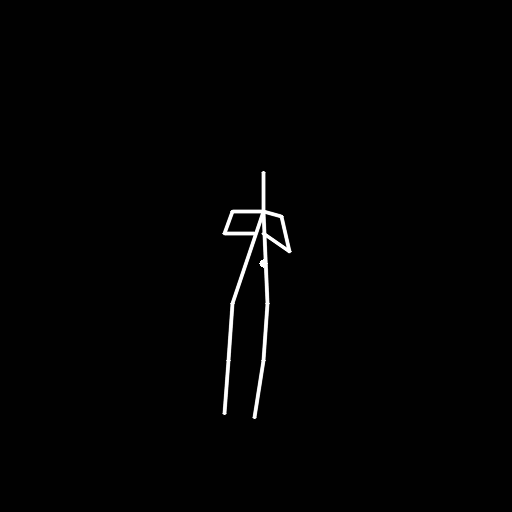

In [26]:
draw_graph(train_dataset[30].x, edge_index)

# **Train The Graph convolution Network**

In [27]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

In [31]:
class GCN(torch.nn.Module):
  def __init__(self, hidden_channels, num_node_features, num_classes):
    super().__init__()
    torch.manual_seed(12345)

    self.conv1 = GCNConv(num_node_features, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, hidden_channels)
    self.conv3 = GCNConv(hidden_channels, hidden_channels)
    self.lin = Linear(hidden_channels, num_classes)

  def forward(self, x, edge_index, batch):
    #1. Obtain node embeddings
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.conv2(x, edge_index)
    x = F.relu(x)
    x = self.conv3(x, edge_index)

    #2. Readout layers(get graph embeddings)
    x = global_mean_pool(x, batch) #[batch-size, hidden_channels]
  
    #3. Apply a final classifier
    x = F.dropout(x, p=0.5, training= self.training)
    x = self.lin(x)
    
    return x

In [33]:
model = GCN(64, train_dataset.num_node_features, train_dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

In [34]:
print(model)

GCN(
  (conv1): GCNConv(2, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=3, bias=True)
)


In [35]:
def train():
  model.train()

  for data in train_loader:
    out = model(data.x, data.edge_index, data.batch)
    loss = loss_fn(out, data.y)
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    optimizer.zero_grad() # Clear gradients.

In [36]:
@torch.no_grad()
def test(loader):
  model.eval()

  correct = 0
  for data in loader:
    out = model(data.x, data.edge_index, data.batch)
    pred = out.argmax(dim=1)
    correct += int((pred == data.y).sum())
  return correct/len(loader.dataset)

In [37]:
for epoch in range(1, 165):
  train()
  train_acc = test(train_loader)
  test_acc = test(test_loader)
  print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.8345, Test Acc: 0.8046
Epoch: 002, Train Acc: 0.8528, Test Acc: 0.8317
Epoch: 003, Train Acc: 0.8184, Test Acc: 0.7960
Epoch: 004, Train Acc: 0.8737, Test Acc: 0.8445
Epoch: 005, Train Acc: 0.8595, Test Acc: 0.8417
Epoch: 006, Train Acc: 0.8718, Test Acc: 0.8759
Epoch: 007, Train Acc: 0.8774, Test Acc: 0.8616
Epoch: 008, Train Acc: 0.8827, Test Acc: 0.8702
Epoch: 009, Train Acc: 0.8068, Test Acc: 0.8003
Epoch: 010, Train Acc: 0.8782, Test Acc: 0.8702
Epoch: 011, Train Acc: 0.8883, Test Acc: 0.8745
Epoch: 012, Train Acc: 0.9028, Test Acc: 0.8944
Epoch: 013, Train Acc: 0.8804, Test Acc: 0.8616
Epoch: 014, Train Acc: 0.8363, Test Acc: 0.8388
Epoch: 015, Train Acc: 0.8322, Test Acc: 0.8274
Epoch: 016, Train Acc: 0.9010, Test Acc: 0.8887
Epoch: 017, Train Acc: 0.9006, Test Acc: 0.8916
Epoch: 018, Train Acc: 0.8868, Test Acc: 0.8730
Epoch: 019, Train Acc: 0.9122, Test Acc: 0.9030
Epoch: 020, Train Acc: 0.8991, Test Acc: 0.8987
Epoch: 021, Train Acc: 0.9133, Test Acc: